Solving the Fisher ODE
---------------------

This jupyter notebook presents a numerical solution to the Fisher ODE,
which describes the shape of the travelling wave in the Fisher-KPP equation.

$$
\begin{cases}
       U' = V \\
       V' = - f(U)/D_1 - c V/D_1
\end{cases}
$$

Here we consider values $ 0 \leq c \leq c_{critical}$ - usually travelling waves do not exist in this parameter range, 
but they do appear in the *Pushing the Boundary* model with an explicitly moving boundary.

#### Setting up the python environment

In [6]:
# import dependencies
import numpy as np
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt

from ipywidgets import interact

In [315]:
# we want interactive plots using the widgets etc.
# it's probably better to call this in a cell separate from the matplotlib imports
# maybe they have to be finished before the %magic can work
%matplotlib notebook

# we define a standard figsize which uses the whole width of the screen
# may vary with client resolution, adjust to your setup!
figsize = (9,4)


### 1.Define the equation

First of all, we introduce the default growth function: the logistsic growth.

In [8]:
def logistic_growth(x):
    return np.multiply(x,1-x)

We define the vector-valued function to be plotted in the phase diagram.

In [80]:
def derivative(t,y,c=1,D1=1,f=lambda x : np.multiply(x,1-x),**kwargs):
    """
    Returns the derivatives of the Fisher-ODE as needed for np.scipy.solve_ivp
    
    Inputs
    ------
    y    array of shape (2,k)
    c    positive scalar, wave speed
    D1   positive scalar, diffusion coefficient
    f    scalar function, mapping state U to growth rate f(U)
         default: exponential growth
    
    Returns
    -------
    y_prime  array of length (2,k)
    
    Example
    -------
    >>> U = np.ones(3)
    >>> V = np.ones(3)*0
    >>> y = np.stack((U,V))
    >>> t=1
    >>> print(derivative(t,y,c=2))
    [[ 0.  0.  0.]
     [-0. -0. -0.]]
    
    """
    # unpack the two variables
    U = y[0]
    V = y[1]
    
    # assert len(U)==len(V), "Input arrays must have the same length N."
    
    #calculate derivative using usual notation
    U_prime = V
    V_prime = -f(U)/D1 - c*V/D1
    
    # pack return variable
    y_prime = np.zeros(y.shape)
    y_prime[0] = U_prime
    y_prime[1] = V_prime
    
    return y_prime

We test the implemented derivative.

In [81]:
U = np.ones(3)
V = np.ones(3)*0
y = np.stack((U,V))
print(y)
print(np.allclose(y[0],U))
t=1
print(derivative(t,y,c=2))

[[1. 1. 1.]
 [0. 0. 0.]]
True
[[ 0.  0.  0.]
 [-0. -0. -0.]]


Seems to work well.

We define the slope b(c) of the intersection $U_0(c)= b/D_1 V_0(c)$.
This must hold for the boundary condition.

In [82]:
def b(c=1,D1=1,D2=1,alpha1=1,alpha2=1,m=1,**kwargs):
    """Returns b(c) as it appears in the slope associated to the boundary condition"""
    
    # Check that all parameters are positive 
    for var in [c,D1,alpha2,m]:
        assert var >=0, "Variable must be greater or equal than zero"
    for var in [D2,alpha1]:
        assert var > 0, "Variable must be greater than zero"
        
    # we define an auxiliary variable, just as in the script
    nu_minus = ( - c - np.sqrt(c**2 + 4*D2*m))/(2*D2)
    b = -c + (D2*nu_minus +c)*(D1*alpha2)/(D2*alpha1)
    return b

In [113]:
def slope_bc(c=1,D1=1,D2=1,alpha1=1,alpha2=1,m=1,**kwargs):
    """Returns slope such that V_0 = slope_bc * U_0 """
    denominator = b(c=c,D1=D1,D2=D2,alpha1=alpha1,alpha2=alpha2,m=m,**kwargs)
    assert denominator != 0, "Slope of boundary condition is infinite!"
    return D1/denominator

In [84]:
print(b())
print(b(c=0))
print(b(alpha1=0))

-1.618033988749895
-1.0


AssertionError: Variable must be greater than zero

### 2. Numerical Simulation

In [200]:
def get_solution(max_step = 2e-1,**kwargs):
    """ Returns solution to Fisher ODE
    INPUTS
    ------
    max_step    maximum time step: the smaller, the smoother the plot
    """
    # maximum time
    # in most cases this will not be effective due to the event below
    T = 1e2 
    # initial value
    # we need to add a little disturbance from equilibrium
    U_0 = 1
    V_0 = 0 - 1e-7


    # add event to stop when we first cross the  V-axis again and V becomes positive
    # this saves us computation time
    def hit_Vaxis(t, y): return y[1]
    hit_Vaxis.terminal = True
    hit_Vaxis.direction = 1
    

    # When do we hit the boundary condition?
    def hit_bc(t,y):
        """ auxiliary function to identify crossing of boundary condition
        EXAMPLE
        -------
        >>> hit_bc(1,np.array([1,0]),c=0,m=0.5)
        1.414213562373095
        """
        # unpack variables for the sake of notation
        U = y[0]
        V = y[1]
        return V - slope_bc(**kwargs)*U

    # We do not stop the calculation when we arrive at boundary condition
    hit_bc.terminal =0
    # direction of crossing: starting from (1,0) we go from hit_bc > 0 to hit_bc <0
    hit_bc.direction = -1

    # When do we pass through the minimum of V(z) ?
    def hit_Vmin(t,y):
        """Returns r$V'$ at position (U,V) = (y[0],y[1])
        EXAMPLE
        -------
        >>> hit_Vmin(1,np.array([0.1]),c=0,D1=3)
        0.0
        """
        return derivative(t=t,y=y,**kwargs)[1]

    # We do not stop the calculation when arrive at the minimum
    hit_Vmin.terminal = 0
    # direction of crossing: starting from (1,0) we go from V' < 0 to V' >0
    hit_Vmin.direction = +1
    
    # collect all events
    events = [hit_bc,hit_Vmin,hit_Vaxis]
    
    # Wrapper to plug derivative with non-standard parameters into solve_ivp"""
    def fun(t,y):
        return derivative(t,y,**kwargs)

    sol = solve_ivp(fun,(0,T),np.array([U_0,V_0]), vectorized=True, method='Radau', events=events,max_step = max_step,\
                    dense_output= True)
    return sol

### 3. Plot the results

In [201]:
def plot_solution(sol):
    # for notational purposes we unpack the solution
    U = sol.y[0]
    V = sol.y[1]
    
    
    fig = plt.figure(figsize=(9,4))
    
    # create subplots
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)

    # plot the solution curve in U-V space
    ax1.plot(U,V)
    # set spine position
    spines = ax1.spines
    spines['left'].set_position(('data',0.0))
    spines['bottom'].set_position(('zero'))
    spines['right'].set_visible(False)
    spines['top'].set_visible(False)
    # set axis labels
    ax1.set_xlabel(r"$U$")
    ax1.set_ylabel(r"$V$")
    # set title
    ax1.set_title("The solution curve")

    # plot the wave profile
    ax2.plot(sol.t,U)
    # set labels
    ax2.set_xlabel(r"$z$")
    ax2.set_ylabel(r"$U(z)$")
    # set title
    ax2.set_title("The travelling wave front")
    
    # return figure for further use
    return fig

In [202]:
sol1 = get_solution(c=1)

<IPython.core.display.Javascript object>


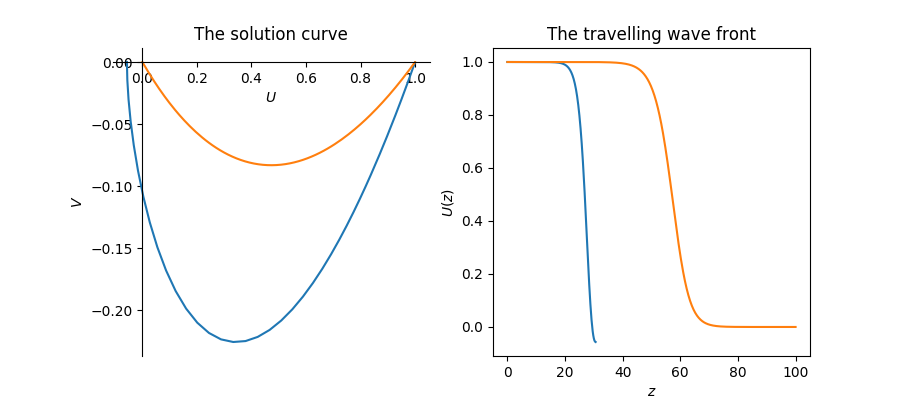

In [203]:
fig = plot_solution(sol1)

### 4. Interactive Plots

In [204]:
def plot_solution_update(sol,fig,clear=False):
    """updates a figure created with plot_solution"""
    # for notational purposes we unpack the solution
    U = sol.y[0]
    V = sol.y[1]
    
    # create subplots
    assert (len(fig.get_axes())==2), "We need a figure with exactly two subplots."
    
    ax1, ax2 = fig.get_axes()
    
    # remove the existing curves if necessary
    if clear:
        for ax in [ax1,ax2]:
            for line in ax.get_lines():
                line.remove()

    # plot the solution curve in U-V space
    ax1.plot(U,V)

    # plot the wave profile
    ax2.plot(sol.t,U)
    
    fig.show()
    return fig
 

In [205]:
sol3 = get_solution(c=3)

In [206]:
fig = plot_solution_update(sol3,fig)

In [207]:
sol0 = get_solution(c=0)

<IPython.core.display.Javascript object>


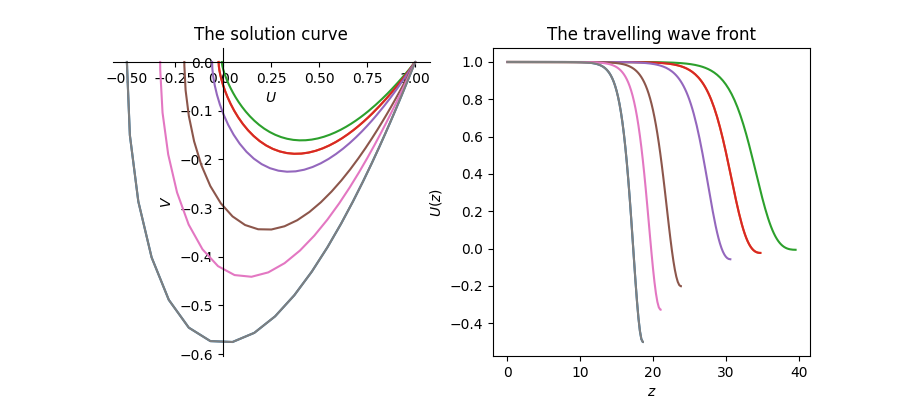

In [208]:
fig = plot_solution(sol0)

In [94]:
def update(c = (0,3,0.25)):
    sol = get_solution(c=c)
    #fig.clear()
    plot_solution_update(sol,fig,clear=False)
    
interact(update);

interactive(children=(FloatSlider(value=1.0, description='c', max=3.0, step=0.25), Output()), _dom_classes=('w…

### 5. Refactor the plotting routine: split the two plots apart

In [260]:
def update_plot(plot_args,ax,clear=False,**kwargs):
    """abstract function to update ax (=plot) by calling ax.plot(plot_arguments)"""
    # remove the existing curves if necessary
    if clear:
            for line in ax.get_lines():
                line.remove()

    ax.plot(*plot_args,**kwargs)
    return ax

In [267]:
def update_plot_sol_curve(sol,ax, clear=False, **kwargs):
    """updates an axe created with plot_sol_curve"""
    # for notational purposes we unpack the solution
    U = sol.y[0]
    V = sol.y[1]
    
    return update_plot((U,V),ax,clear,**kwargs)

In [268]:
def plot_sol_curve(sol,ax,**kwargs):
    """initializes an axe to plot the solution curve"""
    # set spine position
    spines = ax.spines
    spines['left'].set_position(('data',0.0))
    spines['bottom'].set_position(('zero'))
    spines['right'].set_visible(False)
    spines['top'].set_visible(False)
    # set axis labels
    ax.set_xlabel(r"$U$")
    ax.set_ylabel(r"$V$")
    # set title
    ax.set_title("The solution curve")
    
    return update_plot_sol_curve(sol,ax,clear=False,**kwargs)

In [269]:
def update_plot_wave_profile(sol,ax, clear=False,**kwargs):
    """updates an axe by plotting the wave_profile"""
    # for notational purposes we unpack the solution
    U = sol.y[0]
    t = sol.t
    
    return update_plot((t,U),ax,clear,**kwargs)

In [270]:
def plot_wave_profile(sol,ax,**kwargs):
    """initializes an axe to plot the wave profile"""
    # set labels
    ax.set_xlabel(r"$z$")
    ax.set_ylabel(r"$U(z)$")
    # set title
    ax.set_title("The travelling wave profile")
    return update_plot_wave_profile(sol,ax,clear=False,**kwargs)


In [273]:
def plot_summary(sol):
    fig = plt.figure(figsize=(9,4))
    
    # To the left we plot the solution curve
    ax1 = fig.add_subplot(1,2,1)
    plot_sol_curve(sol,ax1)
    
    #To the right we plot the wave profile
    ax2 = fig.add_subplot(1,2,2)
    plot_wave_profile(sol,ax2)
    
    return

<IPython.core.display.Javascript object>


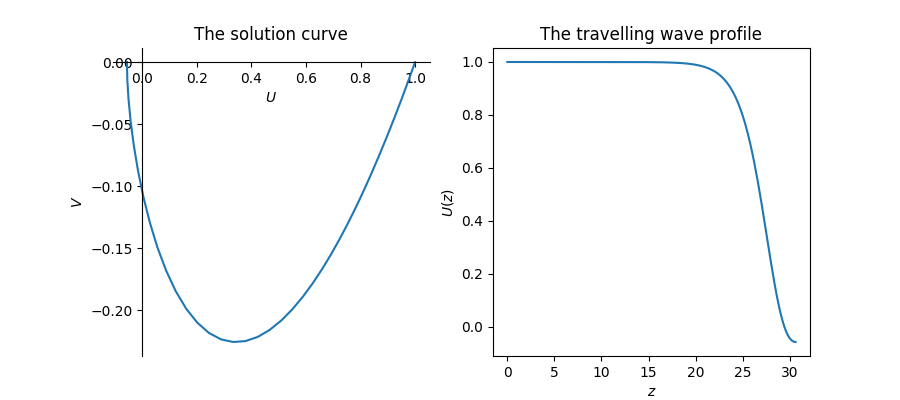

In [274]:
plot_summary(sol1)

### 5. Finding the intersection point between solution curve and boundary condition

Here we use a special feature of the ODE solver >solve_ivp<. 
We can pass so called >events< to it, and it determines the point in time when this event occurs.
Two events are of interest:
1. When do we hit the boundary condition given by the straight line $V = D1/b U$ ?
2. When do we reach the minimum along the V-axis ? 
   I suspect that the point of intersection will always be close to it so we can use it as a proxy,
   at least for $c \sim c_{crit}$.

In [275]:
# We first introduce a dictionary of keywoard parameters
# These include model parameters AND simulation parameters such as max_step
opts = dict(c=1,D1=1,D2=1,alpha1=1,alpha2=1,m=1,k=3)

In [276]:
sol = get_solution(**opts)

Let's calculate the event times with solve_ip.

In [277]:
# Observe the order of events defined in get_solution:
# first hit_bc, then hit_Vmin and finally hit_Vaxis where thecalculation stops
print(sol.t_events)

[array([27.46204992]), array([27.55492355]), array([30.61843742])]


In [278]:
def get_bc_intersection(sol):
    """Returns (U_0,V_0): coordinates of intersection with slope from boundary condition"""
    assert len(sol.t_events[0]) <= 1, "More than one possible intersection with boundary condition!"
    assert len(sol.t_events[0]) > 0, "No intersection point found!"

    # identify the intersection time
    t_bc = sol.t_events[0]
    #use dense solution to map to coordinates 
    return sol.sol(t_bc)

def get_Vmin(sol):
    """Returns coordinates of minimum of V(U) """
    # due to numerical approximation we tend to get TWO minima,
    # the first one being very close to (1,0) where V' is indeed zero
    assert len(sol.t_events[1]) <= 2 , "More than one minimum!"
    
    # Hence we pick the second one
    t_Vmin = sol.t_events[1].max()
    return sol.sol(t_Vmin)

In [348]:
def plot_bc_slope(slope_bc,ax, **kwargs):
    """Plots the slope associated to the boundary condition"""
    # here the upper bound could be 0.5 as it has been determinend empirically by looking at the plots that 
    # for all c we know Ü_bc < 0.45
    x = np.linspace(0,1,10)
    y = slope_bc*x
    ax.plot(x,y,**kwargs)
    return ax

def plot_intersection(sol,slope_bc, **kwargs):
    """Plot the solution curve with the intersection line"""
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    # plot solution curve
    ax = plot_sol_curve(sol,ax, **kwargs)
    
    # plot minimum
    U_min, V_min = get_Vmin(sol)
    ax.plot(U_min,V_min, 'r+',label = 'minimum point')
    
    # plot slope coming from bc
    # NOTE: if we were sure, that U_bc,V_bc below are exact,
    # we could just use them to plot the line without having to pass slope_bc as an argument
    # to this function
    ax = plot_bc_slope(slope_bc,ax,linestyle = 'dashed',color ='k',label='boundary condition')
    
    #plot point of intersection
    U_bc, V_bc = get_bc_intersection(sol)
    ax.plot(U_bc,V_bc,'y+',label = 'point of intersection')
    
    # plot the legend
    ax.legend(loc='lower right')
    
    return fig

<IPython.core.display.Javascript object>


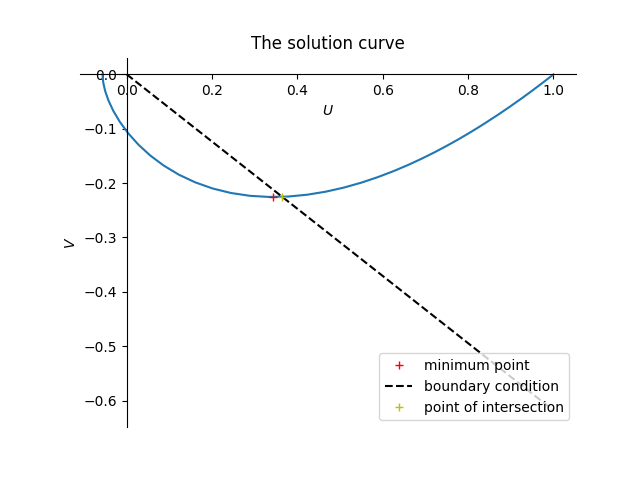

In [349]:
fig = plot_intersection(sol,slope_bc=slope_bc(**opts))

Note that the point of intersection seems to be close to the minimum.
We explore this relation numerically in the following.

### 6. Approximating the intersection by the minimum of $V(U)$

We define a range of values for $c \in [0,c_{crit})$ and compare of $U_{bc}(c),V_{bc}(c)$ evolve compared to $U_{min}(c),V_{min}(c)$.

In [418]:
# We define the critical velocity
# TODO: read it directly from the logistic growth function
c_crit = 2 

# number of solutions we want to compare
N_c = 6

# We define a range of possible parameters for c
# Note that we do NOT include 2, as for example the point of intersection is not well defined
c_range = np.linspace(0,1.99,N_c)
print(c_range)

[0.    0.398 0.796 1.194 1.592 1.99 ]


In [419]:
# we define a dictionary of parameters WITHOUT c
opts = dict(max_step=2e-2)
# Calculate the solutions
sol_range = [get_solution(c=_,**opts) for _ in c_range]

<IPython.core.display.Javascript object>


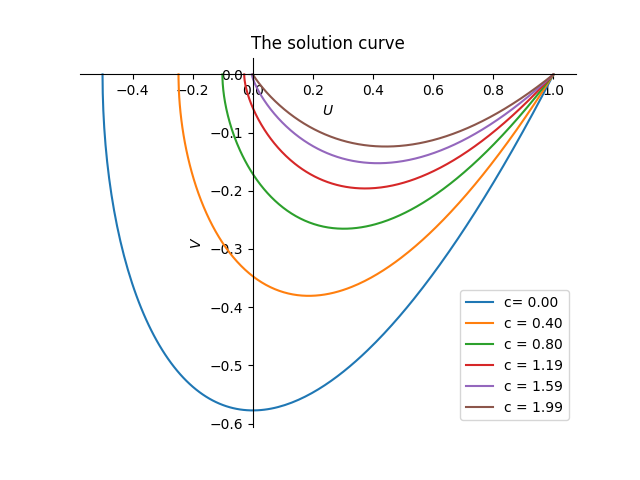

In [420]:
# first we initialize a plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax = plot_sol_curve(sol_range[0],ax, label = "c= %.2f" % c_range[0])

# then we succesively add the other solutions to the plot
for i in range(1,N_c):
    ax = update_plot_sol_curve(sol_range[i],ax,label = "c = %.2f" %c_range[i])
    

ax.legend()

#### b. Minimum $V_{min}(c)$ as a function of $c$

In [421]:
# calculate the coordinates of the minimum for each value of c
min_range = np.array([get_Vmin(sol) for sol in sol_range])
U_min_range = min_range[:,0]
V_min_range = min_range[:,1]
# calculate the intersection point for each value of c
bc_intersection_range = np.array([get_bc_intersection(sol) for sol in sol_range])
U_bc_range = bc_intersection_range[:,0]
V_bc_range = bc_intersection_range[:,1]

<IPython.core.display.Javascript object>


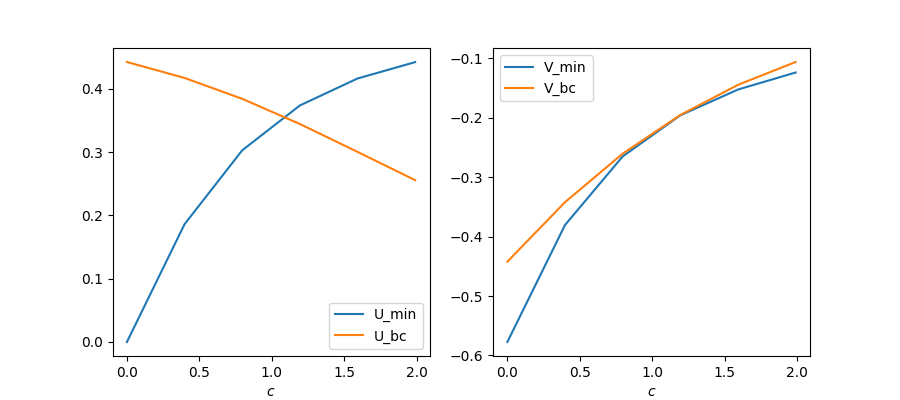

In [422]:
# We plot the dependcy of the min
fig = plt.figure(figsize=figsize)
# To the left we plot the values of U_min and U_bc
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel(r"$c$")
ax1.plot(c_range,U_min_range, label="U_min")
ax1.plot(c_range,U_bc_range, label = "U_bc")
ax1.legend()
# to the right we plot the values of V_min and V_bc
ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel(r"$c$")
ax2.plot(c_range,V_min_range, label = "V_min")
ax2.plot(c_range,V_bc_range, label = "V_bc")
ax2.legend()

##### Two observations

1. It turns out that the agreement between $(U_{min},V_{min})$ and $(U_{bc},V_{bc})$ was just a coincidence for the case $c=1$. But nevertheless the values of $V_{min}$ and $V_{bc}$ seem to agree extremely well for this region --- can we use this to approximate the intersection point around $c \sim 1$ ?
2. Both functions seem to be approximately linear ? Should we just use linear interpolation between $U_{bc}(0)$ and $U_{bc}(2 - \epsilon )$ ?

### 7. Approximate the intersection by sub - and supersolutions

In [423]:
def get_sub_solution(**kwargs):
    """Returns a subsolution to the solution V(u) of the Fisher ODE"""
    return get_solution(c=0,**kwargs)

In [424]:
sol = get_solution(c=1)
sub_sol = get_sub_solution()

<IPython.core.display.Javascript object>


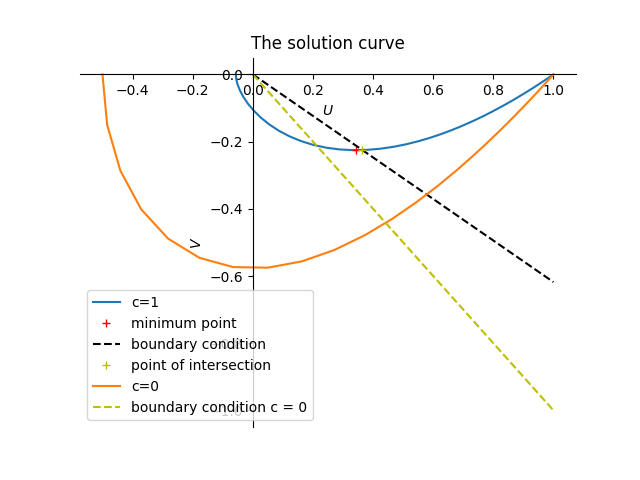

In [425]:
fig = plot_intersection(sol,slope_bc=slope_bc(c=1),label="c=1")
ax = fig.get_axes()[0]
ax = update_plot_sol_curve(sub_sol,ax=ax,label = "c=0")
ax = plot_bc_slope(slope_bc(c=0),ax,linestyle = 'dashed', color ='y', label = "boundary condition c = 0")
ax.legend(loc = "lower left")

We see that the solution curve for $c=0$ is in fact a subsolution to the solution for any  $c \in [0,c_{crit})$.
Hence we can estimate 

$$U_{bc}(c) \leq U_{sub}(c)
\qquad
V_{bc}(c) \geq V_{sub}(c)
$$ 

where $ U_{sub}(c)$ is defined as  the intersection of the sub solution curve with the line $V = \frac{D_1}{b(c)} U$.
                                                                                                  

#### a) Approximation by intersection $U^{sub}_{bc}(c)$  with subsolution

Although we could actually compute the sub solution explicitly by separation of variables, we use a numeric approach here.

In [426]:
U, V  = sub_sol.sol(3)
print(U,V)
print(sub_sol.t.max())

0.9999989982126436 -1.0067657324461655e-06
18.603000649783976


In [427]:
from scipy.optimize import broyden1 as find_zero


def get_bc_intersection_with_subsolution(sub_sol, slope_bc):
    # first we find the time where the two curves intersect
    
    # unfortunately the time guess seems to be critical
    # we choose the real intersection for the sub_solution as a starting point
    time_guess=  sub_sol.t_events[0]
    
    def distance_to_bc(t):
        U,V = sub_sol.sol(t)
        return V - slope_bc*U
    
    t_zero = find_zero(distance_to_bc, time_guess)
    # print("t_zero = %f" % t_zero)
    return sub_sol.sol(t_zero)
    

In [428]:
U_sub_bc, V_sub_bc = get_bc_intersection_with_subsolution(sub_sol, slope_bc=slope_bc(c=1))
print(U_sub_bc,V_sub_bc)

[0.578403] [-0.35747272]


<IPython.core.display.Javascript object>


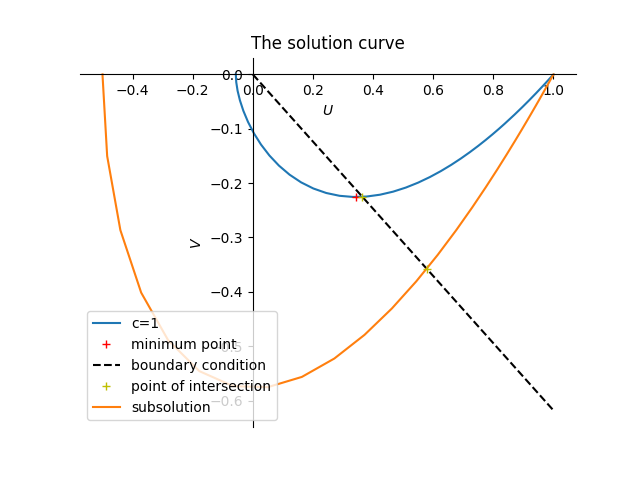

In [429]:
fig = plot_intersection(sol,slope_bc(c=1), label = "c=1")
ax = fig.get_axes()[0]
ax = update_plot_sol_curve(sol=sub_sol,ax=ax,label = "subsolution")
ax.plot(U_sub_bc, V_sub_bc, 'y+')
ax.legend(loc="lower left")

We repeat this plot for a range of values for c as above.

In [430]:
# We exclude the last element c = 2, as we should not get an intersection here
# print(c_range[:N_c -1])
sub_bc_intersection_range = np.array([get_bc_intersection_with_subsolution(sub_sol,slope_bc(_)) for _ in c_range])
U_sub_bc_range = sub_bc_intersection_range[:,0]
V_sub_bc_range = sub_bc_intersection_range[:,1]

<IPython.core.display.Javascript object>


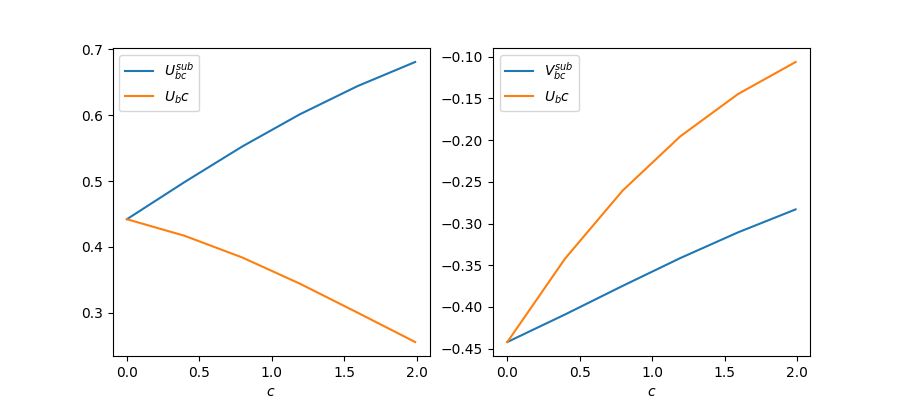

In [432]:
# We plot the dependcy of the min
fig = plt.figure(figsize=figsize)
# To the left we plot the values of U_min and U_bc
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel(r"$c$")
ax1.plot(c_range,U_sub_bc_range, label=r"$U^{sub}_{bc}$")
ax1.plot(c_range,U_bc_range, label = "$U_bc$")
ax1.legend()
# to the right we plot the values of V_min and V_bc
ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel(r"$c$")
ax2.plot(c_range,V_sub_bc_range, label = r"$V^{sub}_{bc}$")
ax2.plot(c_range,V_bc_range, label = r"$U_bc$")
ax2.legend()

#### Observations

Okay, we observe that the estimate is really wasteful concerning $U_{bc}$ --- here we would be better off just estimating $U_{bc}(c)$ by $U_{bc}(0)$, which we can calculate explicitly.
The estimate for $V_{bc}$ does slightly better, but again we could try and interpolate linearly between $V_{bc}(0)$ and $V_{bc}(1.99)$ --- if we could get an explicit expression for the latter!

#### b) Approximate by intersection with supersolution

We are looking for a supersolution (the graph in the U-V plane is above the Fisher ODE solution) which is explicitly solvable. The idea is to estimate (here for $D_1 = 1$)
$$ - c = -\frac{c}{b} \cdot b \leq -\frac{c}{b} \cdot \frac{U}{V}$$
as long as $(U,V)$ above the intersection line.

In [475]:
def super_derivative(t,y,c=1,D1=1,f=lambda x : np.multiply(x,1-x),**kwargs):
    """
    Returns the super derivatives of the Fisher-ODE as needed for np.scipy.solve_ivp
    
    Inputs
    ------
    y    array of shape (2,k)
    c    positive scalar, wave speed
    D1   positive scalar, diffusion coefficient
    f    scalar function, mapping state U to growth rate f(U)
         default: exponential growth
    
    Returns
    -------
    y_prime  array of length (2,k)
    
    """
    # unpack the two variables
    U = y[0]
    V = y[1]
    
    #calculate derivative using usual notation
    U_prime = V
    V_prime = -f(U)/D1 - c*(U-1)/b(c=c,D1=D1,**kwargs)
    
    # pack return variable
    y_prime = np.zeros(y.shape)
    y_prime[0] = U_prime
    y_prime[1] = V_prime
    
    return y_prime

In [476]:
def get_super_solution(max_step = 2e-1,**kwargs):
    """ Returns super solution to Fisher ODE
    INPUTS
    ------
    max_step    maximum time step: the smaller, the smoother the plot
    """
    # maximum time
    # in most cases this will not be effective due to the event below
    T = 1e2 
    # initial value
    # we need to add a little disturbance from equilibrium
    U_0 = 1
    V_0 = 0 - 1e-7


    # add event to stop when we first cross the  V-axis again and V becomes positive
    # this saves us computation time
    def hit_Vaxis(t, y): return y[1]
    hit_Vaxis.terminal = False
    hit_Vaxis.direction = 1
    

    # When do we hit the boundary condition?
    def hit_bc(t,y):
        """ auxiliary function to identify crossing of boundary condition
        EXAMPLE
        -------
        >>> hit_bc(1,np.array([1,0]),c=0,m=0.5)
        1.414213562373095
        """
        # unpack variables for the sake of notation
        U = y[0]
        V = y[1]
        return V - slope_bc(**kwargs)*U

    # We do not stop the calculation when we arrive at boundary condition
    hit_bc.terminal =0
    # direction of crossing: starting from (1,0) we go from hit_bc > 0 to hit_bc <0
    hit_bc.direction = -1

    # When do we pass through the minimum of V(z) ?
    def hit_Vmin(t,y):
        """Returns r$V'$ at position (U,V) = (y[0],y[1])
        EXAMPLE
        -------
        >>> hit_Vmin(1,np.array([0.1]),c=0,D1=3)
        0.0
        """
        return super_derivative(t=t,y=y,**kwargs)[1]

    # We do not stop the calculation when arrive at the minimum
    hit_Vmin.terminal = 0
    # direction of crossing: starting from (1,0) we go from V' < 0 to V' >0
    hit_Vmin.direction = +1
    
    # collect all events
    events = [hit_bc,hit_Vmin,hit_Vaxis]
    
    # Wrapper to plug derivative with non-standard parameters into solve_ivp"""
    def fun(t,y):
        return super_derivative(t,y,**kwargs)

    sol = solve_ivp(fun,(0,T),np.array([U_0,V_0]), vectorized=True, method='Radau', events=events,max_step = max_step,\
                    dense_output= True)
    return sol

In [477]:
sol = get_solution(c=1)
super_sol = get_super_solution(c=1)
print(super_sol.y[1].max(),super_sol.y[1].min())

1.188126024244242 -1.1881727462342453


<IPython.core.display.Javascript object>


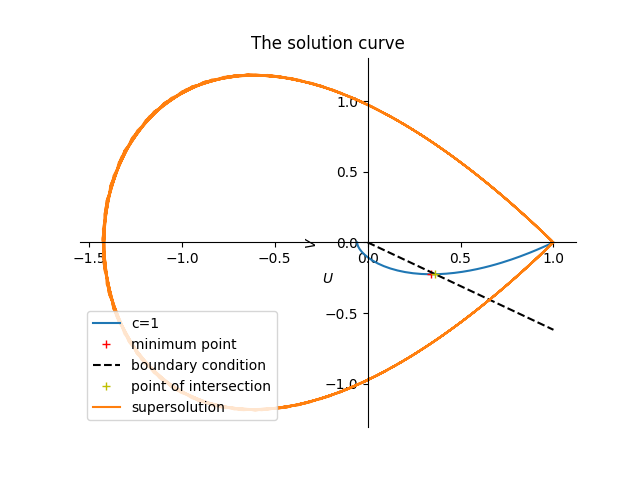

In [478]:
fig = plot_intersection(sol,slope_bc(c=1), label = "c=1")
ax = fig.get_axes()[0]
ax = update_plot_sol_curve(super_sol, ax, label = "supersolution")
ax.legend(loc="lower left")

In [ ]:
Argh. This is pretty hopeless. Finding a differential equation for the supersolution out of the blue.
Maybe just use the linear interpolation between $(1,0)$ and $